In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from lob_data_utils import roc_results, gdf_pca
import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_dir = '../gdf_pca/res_mlp_pca_gdf_que_prev10'
filename_pattern = 'mlp_pca_gdf_{}_len10000_r{}_s{}.csv'
filename_corrected_pattern = 'mlp_corrected_pca_gdf_{}_len10000_r{}_s{}.csv'
data_regular_dir = '../queue_imbalance/data/prepared/'
stocks = list(roc_results.results_10000.keys())
data_length = 10000
should_save_fig = False

In [3]:
mid_prices = []
df_huge = pd.DataFrame()
for stock in stocks:
    df_reg, df_reg_test = lob.load_prepared_data(
        stock, data_dir=data_regular_dir, cv=False, length=data_length)
    mid_prices.append({
        'stock': int(stock), 'mid_price': df_reg['mid_price'].mean(), 
        'spread': (df_reg['ask_price'] - df_reg['bid_price']).mean(),
        'mid_price_negative': len(df_reg[df_reg['mid_price_indicator'] == 0]),
        'mid_price_positive': len(df_reg[df_reg['mid_price_indicator'] == 1])
    })
    #df_huge = df_huge.append(df_reg)
df_regular = pd.DataFrame(mid_prices)
df_regular.head()

,mid_price,mid_price_negative,mid_price_positive,spread,stock
0,280.159303,3916,4084,0.107444,9069
1,439.943869,3986,4014,0.100712,9063
2,449.038569,3908,4092,0.289588,1472
3,1538.635500,3990,4010,1.015375,9094
4,2143.956719,3976,4024,0.650312,9270


In [4]:
#df_huge.columns

In [5]:
# plt.title('Violin Plots of Queue Imbalance vs Mid Price Indicator')

# sns.violinplot(y=df_huge['queue_imbalance'], x=df_huge['mid_price_indicator'], scale="count", split=True)

# plt.ylabel('Queue Imbalance')
# plt.xlabel('Mid Price Indicator')

# plt.ylabel('Queue Imbalance')
# plt.xlabel('Mid Price Indicator')
# if should_save_fig:
#     plt.savefig('all_stocks_violin_plot_imb_vs_ind.png')

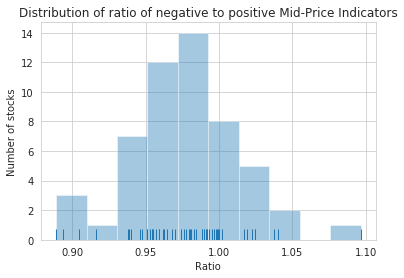

In [6]:
sns.distplot(df_regular['mid_price_negative'] / df_regular['mid_price_positive'], kde=False, rug=True)
plt.xlabel('Ratio')
plt.ylabel('Number of stocks')
plt.title('Distribution of ratio of negative to positive Mid-Price Indicators')
plt.savefig('ratio_mid_price_indicator.png')

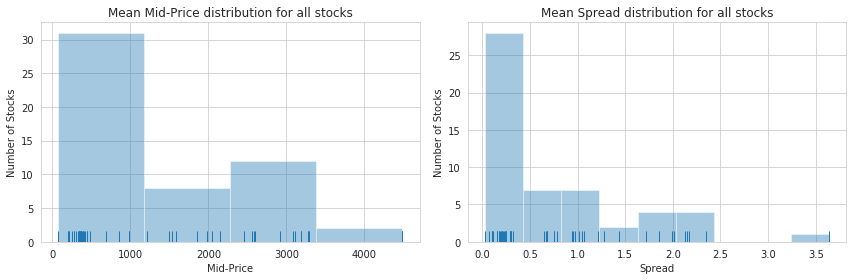

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.distplot(df_regular['mid_price'], kde=False, ax=ax1, rug=True)
ax1.set_xlabel('Mid-Price')
ax1.set_ylabel('Number of Stocks')
ax1.set_title('Mean Mid-Price distribution for all stocks')

sns.distplot(df_regular['spread'], kde=False, ax=ax2, rug=True)
ax2.set_xlabel('Spread')
ax2.set_ylabel('Number of Stocks')

ax2.set_title('Mean Spread distribution for all stocks')
plt.tight_layout()
plt.savefig('mid_price_distribution.png')


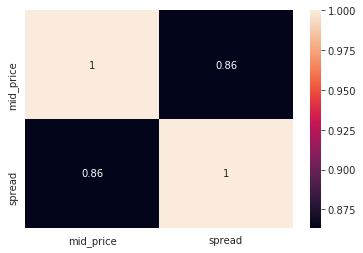

In [8]:
sns.heatmap(df_regular[['mid_price', 'spread']].corr(), annot=True)

Text(0.5,1,'Spread distribution for all stocks')

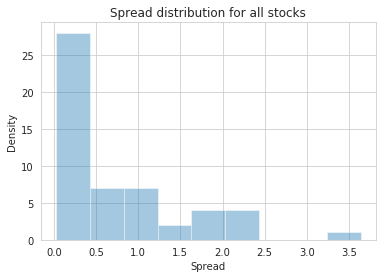

In [9]:
sns.distplot(df_regular['spread'], kde=False)
plt.xlabel('Spread')
plt.ylabel('Density')
plt.title('Spread distribution for all stocks')

In [10]:
df_regular[['mid_price', 'spread']].describe()

,mid_price,spread
count,53.000000,53.000000
mean,1338.327160,0.763437
std,1261.646819,0.785512
min,75.131704,0.026420
25%,352.897625,0.204388
50%,488.642700,0.302538
75%,2462.093375,1.048312
max,4486.275750,3.637750


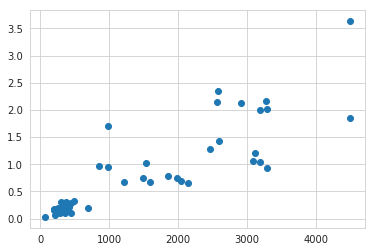

In [11]:
plt.scatter(df_regular['mid_price'], df_regular['spread'])

In [12]:
df_res = pd.DataFrame()
for f in os.listdir(data_dir):
    if not 'corrected' in f:
        parts_of_filename = f.split('_')
        stock = parts_of_filename[3]
        r = parts_of_filename[5][1:]
        s = parts_of_filename[6][1:].split('.csv')[0]
    else:
        parts_of_filename = f.split('_')
        stock = parts_of_filename[4]
        r = parts_of_filename[6][1:]
        s = parts_of_filename[7][1:].split('.csv')[0]
    df_stock = pd.read_csv(os.path.join(data_dir, f))
    df_stock['stock'] = [int(stock)] * len(df_stock)
    if r == '1.0':
        continue
    df_stock['r'] = [float(r)] * len(df_stock)
    df_stock['s'] = [float(s)] * len(df_stock)
    df_res = df_res.append(df_stock)


In [13]:
df_res.columns

Index(['Unnamed: 0', 'alpha', 'f1', 'features', 'hidden_layer_sizes', 'kappa',
       'kernel', 'learning_rate', 'matthews', 'precision', 'r', 'recall',
       'roc_auc', 's', 'solver', 'stock', 'test_f1', 'test_kappa',
       'test_matthews', 'test_precision', 'test_recall', 'test_roc_auc',
       'train_f1', 'train_kappa', 'train_matthews', 'train_precision',
       'train_recall', 'train_roc_auc'],
      dtype='object')

In [14]:
df_res = pd.merge(df_res, df_regular, on='stock')
df_res.columns

Index(['Unnamed: 0', 'alpha', 'f1', 'features', 'hidden_layer_sizes', 'kappa',
       'kernel', 'learning_rate', 'matthews', 'precision', 'r', 'recall',
       'roc_auc', 's', 'solver', 'stock', 'test_f1', 'test_kappa',
       'test_matthews', 'test_precision', 'test_recall', 'test_roc_auc',
       'train_f1', 'train_kappa', 'train_matthews', 'train_precision',
       'train_recall', 'train_roc_auc', 'mid_price', 'mid_price_negative',
       'mid_price_positive', 'spread'],
      dtype='object')

In [15]:
columns = ['stock', 'r', 's', 'alpha','features', 'matthews', 'roc_auc', 
           'test_matthews', 'test_roc_auc', 'train_matthews', 'train_roc_auc', 'mid_price', 'spread']
df_res[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)

,stock,r,s,alpha,features,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,mid_price,spread
3248,11946,0.10,0.1,0.01000,pca_gdf_que_prev10,0.193830,0.595376,0.201930,0.599834,0.196751,0.597931,195.266563,0.172400
5871,3879,0.01,0.1,0.00010,pca_gdf_que_prev10,0.177107,0.588285,0.106171,0.552984,0.179604,0.589746,2462.093375,1.281750
10249,7858,0.10,1.0,0.01000,pca_gdf_que_prev10,0.174937,0.586756,0.138448,0.564298,0.157692,0.578635,4486.275750,3.637750
7242,3035,0.01,0.1,0.10000,pca_gdf_que_prev10,0.174419,0.583789,0.124331,0.554393,0.179238,0.587792,251.878844,0.196388
6854,4320,0.01,1.0,0.00100,pca_gdf_que_prev10,0.170416,0.584709,0.161428,0.580071,0.182618,0.590810,3182.153750,1.994500
3089,12417,0.01,0.1,0.10000,pca_gdf_que_prev10,0.163466,0.580342,0.161349,0.580594,0.156191,0.577576,306.583788,0.300750
7816,10484,0.01,0.1,0.10000,pca_gdf_que_prev10,0.160728,0.579157,0.108563,0.553599,0.145461,0.572059,336.172744,0.292488
9579,9761,0.10,1.0,0.10000,pca_gdf_que_prev10,0.160504,0.578904,0.150322,0.571324,0.155355,0.577130,985.403937,0.957125
4328,1472,0.10,0.1,0.10000,pca_gdf_que_prev10,0.159279,0.577558,0.125772,0.560704,0.146768,0.573094,449.038569,0.289588
9080,1956,0.10,1.0,0.00100,pca_gdf_que_prev10,0.156773,0.576394,0.129694,0.564471,0.130265,0.564377,282.365775,0.156275


In [16]:
df_res[columns][df_res['s'] == 0.1].sort_values(by='matthews', ascending=False).groupby('stock').head(1)

,stock,r,s,alpha,features,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,mid_price,spread
3246,11946,0.10,0.1,0.01000,pca_gdf_que_prev10,0.193830,0.595376,0.201930,0.599834,0.196790,0.597951,195.266563,0.172400
5871,3879,0.01,0.1,0.00010,pca_gdf_que_prev10,0.177107,0.588285,0.106171,0.552984,0.179604,0.589746,2462.093375,1.281750
7242,3035,0.01,0.1,0.10000,pca_gdf_que_prev10,0.174419,0.583789,0.124331,0.554393,0.179238,0.587792,251.878844,0.196388
6942,4320,0.01,0.1,0.01000,pca_gdf_que_prev10,0.168410,0.583838,0.161056,0.580335,0.183391,0.591249,3182.153750,1.994500
3089,12417,0.01,0.1,0.10000,pca_gdf_que_prev10,0.163466,0.580342,0.161349,0.580594,0.156191,0.577576,306.583788,0.300750
10309,7858,0.10,0.1,0.10000,pca_gdf_que_prev10,0.161903,0.580172,0.181733,0.585611,0.149027,0.574109,4486.275750,3.637750
7816,10484,0.01,0.1,0.10000,pca_gdf_que_prev10,0.160728,0.579157,0.108563,0.553599,0.145461,0.572059,336.172744,0.292488
4331,1472,0.10,0.1,0.10000,pca_gdf_que_prev10,0.159279,0.577558,0.125772,0.560704,0.146768,0.573094,449.038569,0.289588
9769,9761,0.01,0.1,0.01000,pca_gdf_que_prev10,0.158205,0.578628,0.134250,0.566334,0.149926,0.574880,985.403937,0.957125
9314,4799,0.01,0.1,0.01000,pca_gdf_que_prev10,0.156744,0.577368,0.159131,0.579602,0.127583,0.562408,979.559531,1.713688


In [17]:
df_best = df_res[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_best

,stock,r,s,alpha,features,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,mid_price,spread
3248,11946,0.10,0.1,0.01000,pca_gdf_que_prev10,0.193830,0.595376,0.201930,0.599834,0.196751,0.597931,195.266563,0.172400
5871,3879,0.01,0.1,0.00010,pca_gdf_que_prev10,0.177107,0.588285,0.106171,0.552984,0.179604,0.589746,2462.093375,1.281750
10249,7858,0.10,1.0,0.01000,pca_gdf_que_prev10,0.174937,0.586756,0.138448,0.564298,0.157692,0.578635,4486.275750,3.637750
7242,3035,0.01,0.1,0.10000,pca_gdf_que_prev10,0.174419,0.583789,0.124331,0.554393,0.179238,0.587792,251.878844,0.196388
6854,4320,0.01,1.0,0.00100,pca_gdf_que_prev10,0.170416,0.584709,0.161428,0.580071,0.182618,0.590810,3182.153750,1.994500
3089,12417,0.01,0.1,0.10000,pca_gdf_que_prev10,0.163466,0.580342,0.161349,0.580594,0.156191,0.577576,306.583788,0.300750
7816,10484,0.01,0.1,0.10000,pca_gdf_que_prev10,0.160728,0.579157,0.108563,0.553599,0.145461,0.572059,336.172744,0.292488
9579,9761,0.10,1.0,0.10000,pca_gdf_que_prev10,0.160504,0.578904,0.150322,0.571324,0.155355,0.577130,985.403937,0.957125
4328,1472,0.10,0.1,0.10000,pca_gdf_que_prev10,0.159279,0.577558,0.125772,0.560704,0.146768,0.573094,449.038569,0.289588
9080,1956,0.10,1.0,0.00100,pca_gdf_que_prev10,0.156773,0.576394,0.129694,0.564471,0.130265,0.564377,282.365775,0.156275


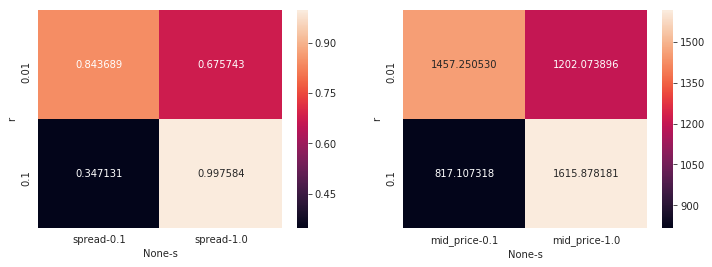

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
df_best1 = df_best[['r', 's', 'spread']]
sns.heatmap(df_best1.groupby(['r', 's']).mean().unstack(), annot=True, fmt='f', ax=ax1)
df_best1 = df_best[['r', 's', 'mid_price']]
sns.heatmap(df_best1.groupby(['r', 's']).mean().unstack(), annot=True, fmt='f', ax=ax2)

In [19]:
# mean 1338.327160 0.763437

df_smallest = df_res[df_res['mid_price'] < 1338.32]
df_smallest = df_smallest[df_smallest['spread'] < 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.01]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_smallest['matthews'].mean()

0.10479107719943676

In [20]:
df_smallest = df_res[df_res['mid_price'] > 1338.32]
df_smallest = df_smallest[df_smallest['spread'] < 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.1]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_smallest['test_matthews'].mean()

0.10272072309555737

In [21]:
df_smallest = df_res[df_res['mid_price'] < 1338.32]
df_smallest = df_smallest[df_smallest['spread'] > 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.01]
df_smallest = df_smallest[df_smallest['s'] == 1.0]
df_smallest[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_smallest['test_matthews'].mean()

0.1404426238486955

In [22]:
df_smallest = df_res[df_res['mid_price'] < 1338.32]
df_smallest = df_smallest[df_smallest['spread'] < 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.1]
df_smallest = df_smallest[df_smallest['s'] == 1.0]
df_smallest[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_smallest['test_matthews'].mean()

0.1150287339143097

In [23]:
df_best['r'].value_counts(), df_best['s'].value_counts()

(0.01    40
 0.10    13
 Name: r, dtype: int64, 0.1    32
 1.0    21
 Name: s, dtype: int64)

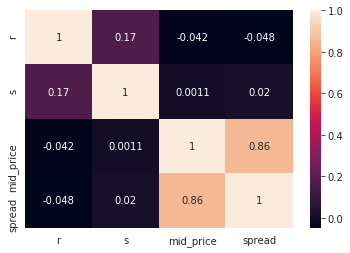

In [24]:
sns.heatmap(df_best[['r', 's', 'mid_price', 'spread']].corr(), annot=True)

,test_matthews,matthews,test_roc_auc,roc_auc
count,53.000000,53.000000,53.000000,53.000000
mean,0.117582,0.136915,0.557603,0.567173
std,0.029440,0.023078,0.014672,0.011520
min,0.057528,0.077579,0.528760,0.538525
25%,0.097691,0.124500,0.546701,0.561568
50%,0.115801,0.137925,0.556325,0.567712
75%,0.133798,0.149581,0.564471,0.573938
max,0.201930,0.193830,0.599834,0.595376


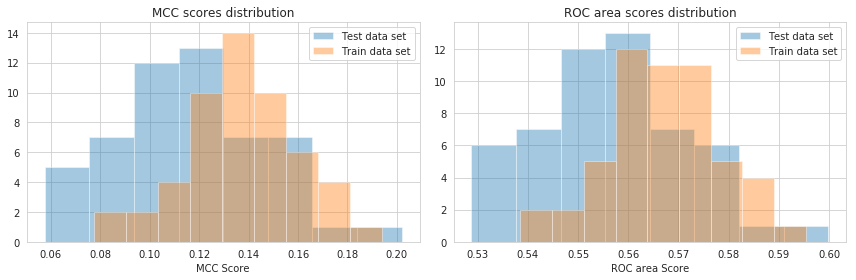

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.distplot(df_best['test_matthews'], kde=False, label='Test data set', ax=ax1)
sns.distplot(df_best['matthews'], kde=False, label='Train data set', ax=ax1)

ax1.legend()
ax1.set_xlabel('MCC Score')
ax1.set_title('MCC scores distribution')

sns.distplot(df_best['test_roc_auc'], kde=False, label='Test data set', ax=ax2)
sns.distplot(df_best['roc_auc'], kde=False, label='Train data set', ax=ax2)

ax2.legend()
ax2.set_xlabel('ROC area Score')
ax2.set_title('ROC area scores distribution')
plt.tight_layout()
plt.savefig('results_mlp_pca_score_dist.png')

df_best[['test_matthews', 'matthews', 'test_roc_auc', 'roc_auc']].describe()

In [26]:
df_best.melt(['stock', 'r', 's', 'alpha', 'features'])

,stock,r,s,alpha,features,variable,value
0,11946,0.10,0.1,0.01000,pca_gdf_que_prev10,matthews,0.193830
1,3879,0.01,0.1,0.00010,pca_gdf_que_prev10,matthews,0.177107
2,7858,0.10,1.0,0.01000,pca_gdf_que_prev10,matthews,0.174937
3,3035,0.01,0.1,0.10000,pca_gdf_que_prev10,matthews,0.174419
4,4320,0.01,1.0,0.00100,pca_gdf_que_prev10,matthews,0.170416
5,12417,0.01,0.1,0.10000,pca_gdf_que_prev10,matthews,0.163466
6,10484,0.01,0.1,0.10000,pca_gdf_que_prev10,matthews,0.160728
7,9761,0.10,1.0,0.10000,pca_gdf_que_prev10,matthews,0.160504
8,1472,0.10,0.1,0.10000,pca_gdf_que_prev10,matthews,0.159279
9,1956,0.10,1.0,0.00100,pca_gdf_que_prev10,matthews,0.156773


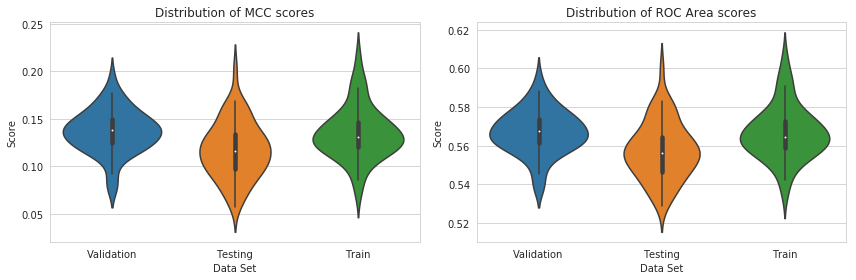

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

df = df_best.copy()
df.rename(columns={'matthews': 'Validation', 'test_matthews': 'Testing', 'train_matthews': 'Train'}, inplace=True)
df = df.melt(['stock', 'r', 's', 'alpha', 'features', 'spread', 'mid_price', 
                   'roc_auc', 'test_roc_auc', 'train_roc_auc'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_best.copy()
df.rename(columns={'roc_auc': 'Validation', 'test_roc_auc': 'Testing', 'train_roc_auc': 'Train'}, inplace=True)
df = df.melt(['stock', 'r', 's', 'alpha', 'features', 'spread', 'mid_price', 
                   'matthews', 'test_matthews', 'train_matthews'])

ax2.set_title('Distribution of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')
plt.tight_layout()
plt.savefig('violin_distribution_scores_mlp.png')

In [28]:
print(df_best[['test_matthews', 'matthews', 'test_roc_auc', 'roc_auc']].describe().to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  test\_matthews &   matthews &  test\_roc\_auc &    roc\_auc \\
\midrule
count &      53.000000 &  53.000000 &     53.000000 &  53.000000 \\
mean  &       0.117582 &   0.136915 &      0.557603 &   0.567173 \\
std   &       0.029440 &   0.023078 &      0.014672 &   0.011520 \\
min   &       0.057528 &   0.077579 &      0.528760 &   0.538525 \\
25\%   &       0.097691 &   0.124500 &      0.546701 &   0.561568 \\
50\%   &       0.115801 &   0.137925 &      0.556325 &   0.567712 \\
75\%   &       0.133798 &   0.149581 &      0.564471 &   0.573938 \\
max   &       0.201930 &   0.193830 &      0.599834 &   0.595376 \\
\bottomrule
\end{tabular}



In [29]:
df_best = df_res[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)

df_log = pd.read_csv('res_log_que.csv')
df_best = pd.merge(df_best, df_log, on='stock', suffixes=['_mlp', '_log'])

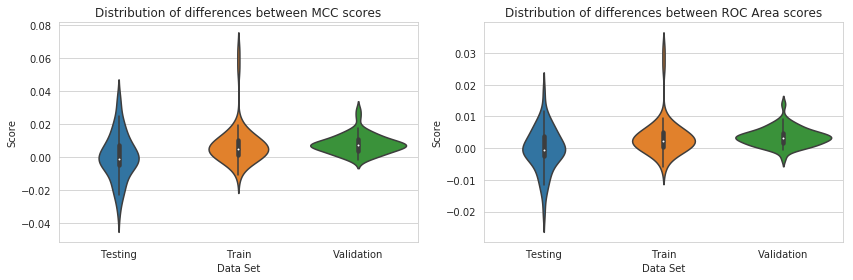

In [30]:
#sns.violinplot(df_best['test_matthews_mlp'] - df_best['test_matthews_log'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

df = df_best.copy()
columns = ['stock', 'r', 's', 'alpha', 'features', 'matthews_mlp', 'roc_auc_mlp',
       'test_matthews_mlp', 'test_roc_auc_mlp', 'train_matthews_mlp',
       'train_roc_auc_mlp', 'mid_price', 'spread', 'Unnamed: 0', 'f1', 'kappa',
       'matthews_log', 'precision', 'recall', 'roc_auc_log', 'test_f1_score',
       'test_kappa', 'test_matthews_log', 'test_precision', 'test_recall',
       'test_roc_auc_log', 'train_f1', 'train_kappa', 'train_matthews_log',
       'train_precision', 'train_recall', 'train_roc_auc_log']

df['test_matthews_diff'] = df['test_matthews_mlp'] - df['test_matthews_log']
df['train_matthews_diff'] = df['train_matthews_mlp'] - df['train_matthews_log']
df['validation_matthews_diff'] = df['matthews_mlp'] - df['matthews_log']
df.rename(columns={'validation_matthews_diff': 'Validation', 'test_matthews_diff': 'Testing', 
                   'train_matthews_diff': 'Train'}, inplace=True)
df = df.melt(columns)
sns.violinplot(x='variable', y='value', data=df, ax=ax1)
ax1.set_title('Distribution of differences between MCC scores')
ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_best.copy()
df['test_roc_auc_diff'] = df['test_roc_auc_mlp'] - df['test_roc_auc_log']
df['train_roc_auc_diff'] = df['train_roc_auc_mlp'] - df['train_roc_auc_log']
df['validation_roc_auc_diff'] = df['roc_auc_mlp'] - df['roc_auc_log']
df.rename(columns={'validation_roc_auc_diff': 'Validation', 'test_roc_auc_diff': 'Testing', 
                   'train_roc_auc_diff': 'Train'}, inplace=True)

df = df.melt(columns)

ax2.set_title('Distribution of differences between ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')
plt.tight_layout()
plt.savefig('violin_distribution_scores_diff_mlp_log.png')


In [31]:
df = df_best.copy()
columns = ['stock', 'r', 's', 'alpha', 'features', 'matthews_mlp', 'roc_auc_mlp',
       'test_matthews_mlp', 'test_roc_auc_mlp', 'train_matthews_mlp',
       'train_roc_auc_mlp', 'mid_price', 'spread', 'Unnamed: 0', 'f1', 'kappa',
       'matthews_log', 'precision', 'recall', 'roc_auc_log', 'test_f1_score',
       'test_kappa', 'test_matthews_log', 'test_precision', 'test_recall',
       'test_roc_auc_log', 'train_f1', 'train_kappa', 'train_matthews_log',
       'train_precision', 'train_recall', 'train_roc_auc_log']

df['test_matthews_diff'] = df['test_matthews_mlp'] - df['test_matthews_log']
df['train_matthews_diff'] = df['train_matthews_mlp'] - df['train_matthews_log']
df['validation_matthews_diff'] = df['matthews_mlp'] - df['matthews_log']
df['test_roc_auc_diff'] = df['test_roc_auc_mlp'] - df['test_roc_auc_log']
df['train_roc_auc_diff'] = df['train_roc_auc_mlp'] - df['train_roc_auc_log']
df['validation_roc_auc_diff'] = df['roc_auc_mlp'] - df['roc_auc_log']

print(df[['test_matthews_diff', 'train_matthews_diff', 'validation_matthews_diff',
   'test_roc_auc_diff', 'train_roc_auc_diff', 'validation_roc_auc_diff']].describe().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  test\_matthews\_diff &  train\_matthews\_diff &  validation\_matthews\_diff &  test\_roc\_auc\_diff &  train\_roc\_auc\_diff &  validation\_roc\_auc\_diff \\
\midrule
count &           53.000000 &            53.000000 &                 53.000000 &          53.000000 &           53.000000 &                53.000000 \\
mean  &            0.000383 &             0.007355 &                  0.007954 &          -0.000344 &            0.003435 &                 0.003606 \\
std   &            0.013839 &             0.012073 &                  0.005762 &           0.006790 &            0.005912 &                 0.002848 \\
min   &           -0.032787 &            -0.010843 &                 -0.001549 &          -0.020214 &           -0.005970 &                -0.003118 \\
25\%   &           -0.004879 &             0.001338 &                  0.003935 &          -0.002473 &            0.000430 &                 0.001776 \\
50\%   &           -0.001009 &  

In [32]:
df[['test_matthews_diff', 'train_matthews_diff', 'validation_matthews_diff',
   'test_roc_auc_diff', 'train_roc_auc_diff', 'validation_roc_auc_diff']].describe()

,test_matthews_diff,train_matthews_diff,validation_matthews_diff,test_roc_auc_diff,train_roc_auc_diff,validation_roc_auc_diff
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,0.000383,0.007355,0.007954,-0.000344,0.003435,0.003606
std,0.013839,0.012073,0.005762,0.006790,0.005912,0.002848
min,-0.032787,-0.010843,-0.001549,-0.020214,-0.005970,-0.003118
25%,-0.004879,0.001338,0.003935,-0.002473,0.000430,0.001776
50%,-0.001009,0.005106,0.007085,-0.000508,0.002264,0.003367
75%,0.007550,0.010281,0.010666,0.003722,0.005015,0.004906
max,0.034444,0.064562,0.028553,0.017770,0.031170,0.013903


In [33]:
print(df[df['test_matthews_diff'] > 0]['stock'].count(), df[df['test_roc_auc_diff'] > 0]['stock'].count())
print(df[df['train_matthews_diff'] > 0]['stock'].count(), df[df['train_roc_auc_diff'] > 0]['stock'].count())
print(df[df['validation_matthews_diff'] > 0]['stock'].count(), df[df['validation_roc_auc_diff'] > 0]['stock'].count())

23 24
44 43
51 51


In [34]:
df[df['test_matthews_diff'] > 0]['stock'].count(), df[df['test_roc_auc_diff'] > 0]['stock'].count()

(23, 24)

In [35]:
df.columns

Index(['stock', 'r', 's', 'alpha', 'features', 'matthews_mlp', 'roc_auc_mlp',
       'test_matthews_mlp', 'test_roc_auc_mlp', 'train_matthews_mlp',
       'train_roc_auc_mlp', 'mid_price', 'spread', 'Unnamed: 0', 'f1', 'kappa',
       'matthews_log', 'precision', 'recall', 'roc_auc_log', 'test_f1_score',
       'test_kappa', 'test_matthews_log', 'test_precision', 'test_recall',
       'test_roc_auc_log', 'train_f1', 'train_kappa', 'train_matthews_log',
       'train_precision', 'train_recall', 'train_roc_auc_log',
       'test_matthews_diff', 'train_matthews_diff', 'validation_matthews_diff',
       'test_roc_auc_diff', 'train_roc_auc_diff', 'validation_roc_auc_diff'],
      dtype='object')

In [39]:
stocks_bad = df[df['test_matthews_diff'] > 0]['stock'].values
d = df_res.sort_values(by='matthews', ascending=False).groupby('stock').head(1)

c = ['stock', 'r', 's', 'alpha','features', 'matthews', 'roc_auc', 
           'test_matthews', 'test_roc_auc', 'train_matthews', 'train_roc_auc', 'mid_price', 'spread']

d[d['stock'].isin(stocks_bad)][c]

,stock,r,s,alpha,features,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,mid_price,spread
7242,3035,0.01,0.1,0.10000,pca_gdf_que_prev10,0.174419,0.583789,0.124331,0.554393,0.179238,0.587792,251.878844,0.196388
3089,12417,0.01,0.1,0.10000,pca_gdf_que_prev10,0.163466,0.580342,0.161349,0.580594,0.156191,0.577576,306.583788,0.300750
7816,10484,0.01,0.1,0.10000,pca_gdf_que_prev10,0.160728,0.579157,0.108563,0.553599,0.145461,0.572059,336.172744,0.292488
9579,9761,0.10,1.0,0.10000,pca_gdf_que_prev10,0.160504,0.578904,0.150322,0.571324,0.155355,0.577130,985.403937,0.957125
4328,1472,0.10,0.1,0.10000,pca_gdf_que_prev10,0.159279,0.577558,0.125772,0.560704,0.146768,0.573094,449.038569,0.289588
9314,4799,0.01,0.1,0.01000,pca_gdf_que_prev10,0.156744,0.577368,0.159131,0.579602,0.127583,0.562408,979.559531,1.713688
5561,2813,0.10,0.1,0.10000,pca_gdf_que_prev10,0.145466,0.571477,0.109217,0.553491,0.135295,0.567378,383.283281,0.204388
3856,3022,0.01,1.0,0.00010,pca_gdf_que_prev10,0.139346,0.567712,0.158247,0.578227,0.118811,0.557858,394.221775,0.208625
11019,3161,0.01,1.0,0.00001,pca_gdf_que_prev10,0.139062,0.568754,0.169354,0.583358,0.134138,0.566371,372.797500,0.150575
10567,4060,0.10,0.1,0.00100,pca_gdf_que_prev10,0.137925,0.567818,0.101320,0.549518,0.147188,0.572638,352.787719,0.251387
